In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from maren_codes import combat as c
from gprofiler import gprofiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# ignore R warning messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3+116.g0075c62 anndata==0.6.22.post2.dev80+g72c2bde umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.24.1 scikit-learn==0.21.3 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


# Filenames

Cell cycle genes were taken from Tirosh et al., Science (2016)

In [3]:
adata_input = '/storage/groups/ml01/datasets/projects/20190117_Wurst_Demuxlet_malte.luecken/ipsc_ipd_patients_raw.h5ad'

adata_out = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_preproc.h5ad'

cc_genes_tirosh = '~/single-cell-tutorial/Tirosh_cell_cycle_genes_human.txt'

# Read in data

In [4]:
adata_pat = sc.read(adata_input)

In [5]:
#Check dataset stats
adata_pat
adata_pat.obs['Lane'].value_counts()
adata_pat.obs['Demux_state'].value_counts()
adata_pat.obs['Donor'].value_counts()

AnnData object with n_obs × n_vars = 30676 × 58735 
    obs: 'Demux_state', 'Donor', 'Lane'

6    5302
5    5302
4    5169
3    5139
2    4935
1    4829
Name: Lane, dtype: int64

SNG    30676
Name: Demux_state, dtype: int64

ERF07E07    4591
ERF20E03    3449
ERF25E02    3288
ERF16E39    3246
ERF23E03    2997
ERF30E05    2749
ERF10E07    2699
ERF03E15    2191
ERF24E01    2159
ERF04E18    1396
ERF06E05    1042
ERF31E02     869
Name: Donor, dtype: int64

# Assign more metadata

In [8]:
adata_pat.obs['Donor'].cat.categories

Index(['ERF03E15', 'ERF04E18', 'ERF06E05', 'ERF07E07', 'ERF10E07', 'ERF16E39',
       'ERF20E03', 'ERF23E03', 'ERF24E01', 'ERF25E02', 'ERF30E05', 'ERF31E02'],
      dtype='object')

In [9]:
adata_pat.obs['condition'] = ['Control' if d in ['ERF16E39', 'ERF20E03', 'ERF30E05', 'ERF04E18', 'ERF31E02'] else 'Parkinson' for d in adata_pat.obs['Donor']]

In [10]:
adata_pat.obs['age'] = [49 if d.startswith('ERF24') else 73 if d.startswith('ERF03') else 64 if d.startswith('ERF06') else 54 if d.startswith('ERF10') else 37 if d.startswith('ERF23') else 63 if d.startswith('ERF25') else 68 if d.startswith('ERF07') else 69 if d.startswith('ERF16') else 53 if d.startswith('ERF20') else 71 if d.startswith('ERF30') else 42 if d.startswith('ERF04') else 66 for d in adata_pat.obs['Donor']]
adata_pat.obs['years_of_illness'] = [1 if d.startswith('ERF24') else 3 if d.startswith('ERF03') else 3 if d.startswith('ERF06') else 3 if d.startswith('ERF10') else 4 if d.startswith('ERF23') else 6 if d.startswith('ERF25') else 7 if d.startswith('ERF07') else np.nan for d in adata_pat.obs['Donor']]
adata_pat.obs['gender'] = ['F' if d in ['ERF16E39', 'ERF31E02', 'ERF25E02'] else 'M' for d in adata_pat.obs['Donor']]

In [132]:
adata_pat.obs.Donor.cat.categories

Index(['ERF03E15', 'ERF04E18', 'ERF06E05', 'ERF07E07', 'ERF10E07', 'ERF16E39',
       'ERF20E03', 'ERF23E03', 'ERF24E01', 'ERF25E02', 'ERF30E05', 'ERF31E02'],
      dtype='object')

In [133]:
adata_pat.rename_categories('Donor', ['UKERiJ2C-R1-015', 'UKERi1JF-R1-018', 'UKERiM89-R1-005', 'UKERiC99-R1-007', 'UKERiR66-R1-007', 'UKERiG3G-R1-039',
       'UKERi1E4-R1-003', 'UKERiAY6-R1-003', 'UKERiPX7-R1-001', 'UKERi88H-R1-002', 'UKERiO3H-R1-005', 'UKERi82A-R1-002'])

# Quality Control

In [6]:
# Quality control - calculate QC covariates
adata_pat.obs['n_counts'] = adata_pat.X.sum(1)
adata_pat.obs['log_counts'] = np.log(adata_pat.obs['n_counts'])
adata_pat.obs['n_genes'] = (adata_pat.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata_pat.var_names]
adata_pat.obs['mt_frac'] = adata_pat.X[:, mt_gene_mask].sum(1)/adata_pat.obs['n_counts']

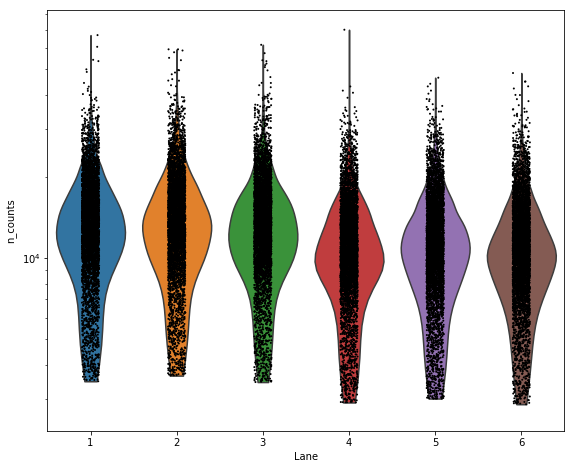

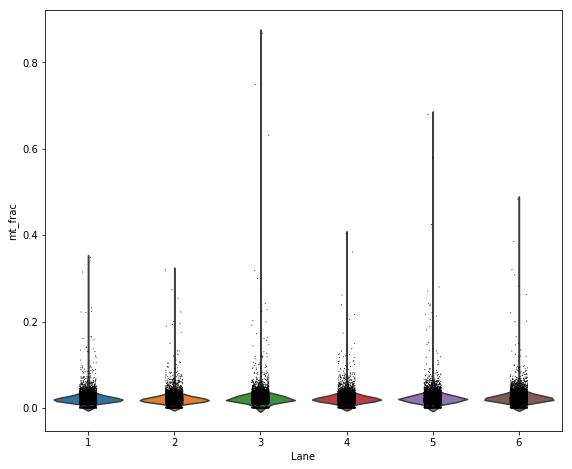

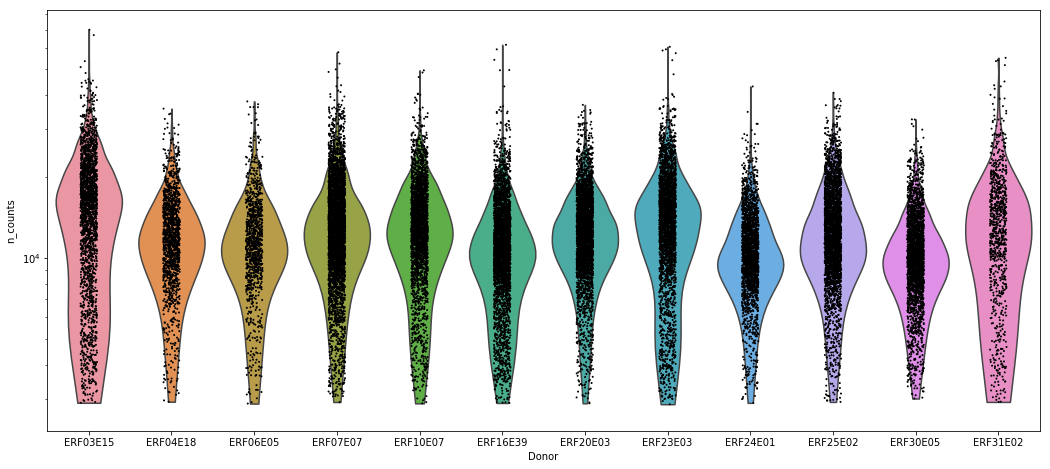

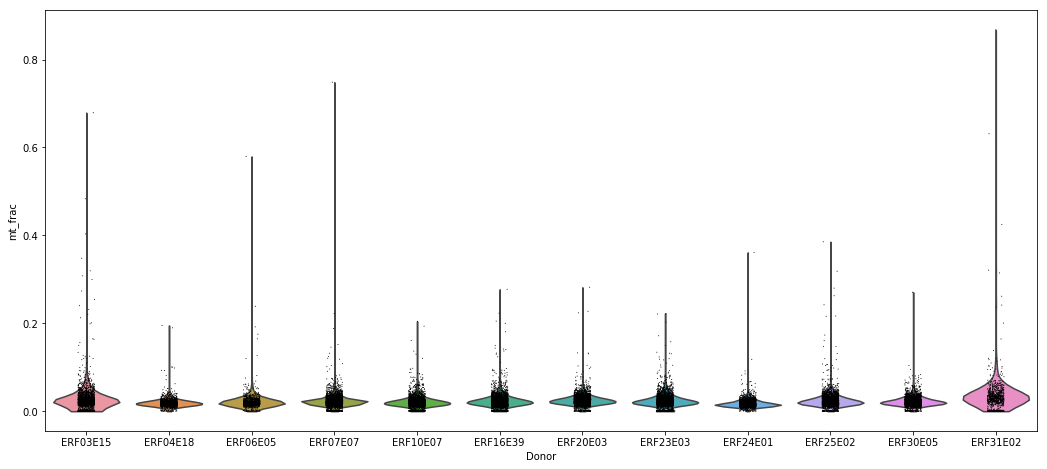

In [7]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata_pat, 'n_counts', groupby='Lane', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata_pat, 'mt_frac', groupby='Lane')

plt.rcParams['figure.figsize']=(14,8) #rescale figures
t3 = sc.pl.violin(adata_pat, 'n_counts', groupby='Donor', size=2, log=True, cut=0)
t4 = sc.pl.violin(adata_pat, 'mt_frac', groupby='Donor', cut=0)
plt.rcParams['figure.figsize']=(8,8) #rescale figures

Data are consistent across lanes, and broadly across Donors. We can filter cells and genes jointly given the above results.

In [22]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0.2, 1, 150))
colors3 = plt.cm.Greys_r(np.linspace(0.5,0.55,30))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

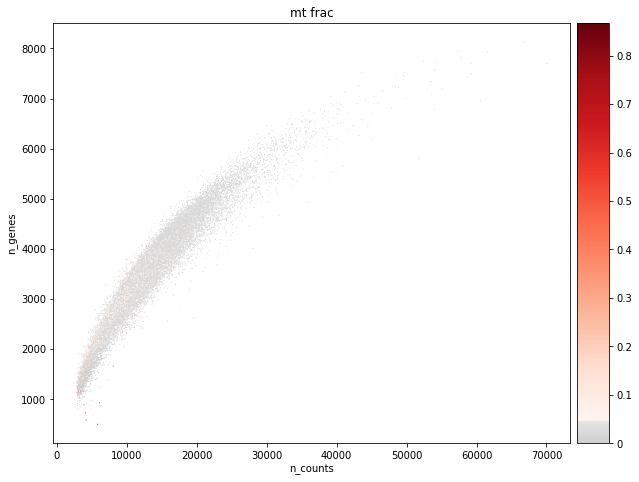

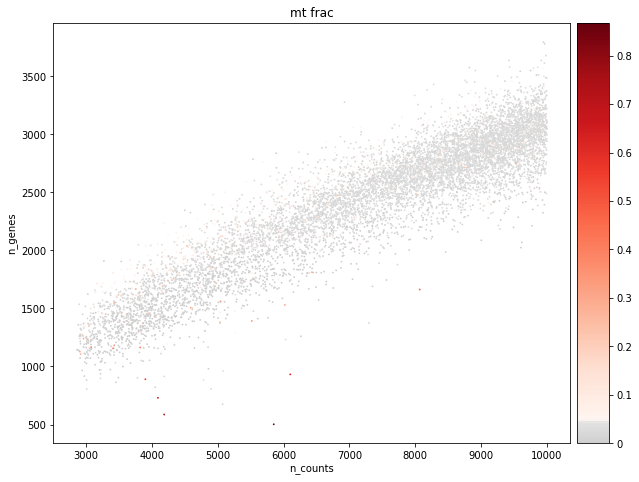

In [11]:
#Data quality summary plots
p1 = sc.pl.scatter(adata_pat, 'n_counts', 'n_genes', color='mt_frac', color_map=mymap)
p2 = sc.pl.scatter(adata_pat[adata_pat.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', color_map=mymap)


Here it looks like n_genes < 1000 should be filtered out, and counts are all fine.

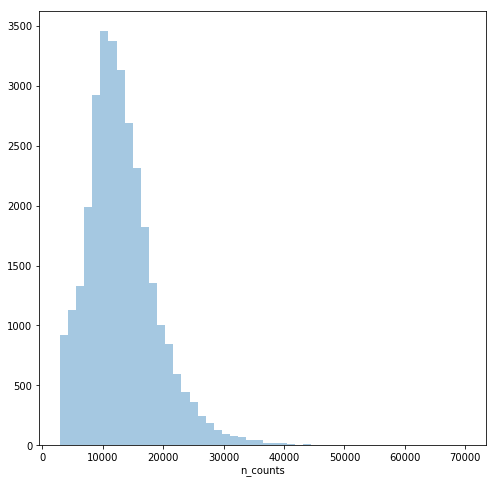

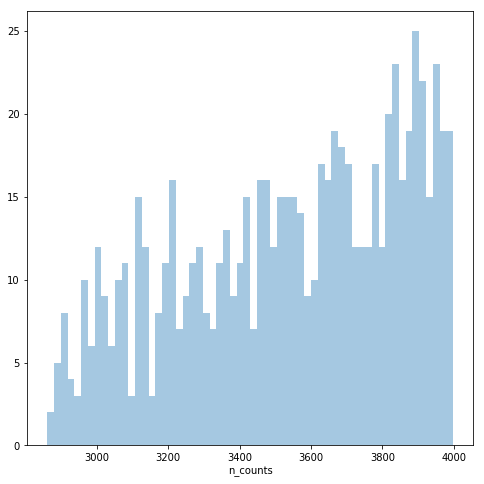

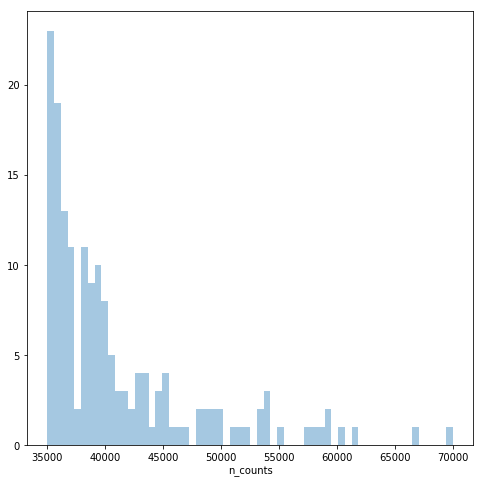

In [11]:
#Thresholding decision: counts
p3 = sb.distplot(adata_pat.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata_pat.obs['n_counts'][adata_pat.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata_pat.obs['n_counts'][adata_pat.obs['n_counts']>35000], kde=False, bins=60)
plt.show()

Count thresholding has already happened by CellRanger. No further thresholding is necessary!

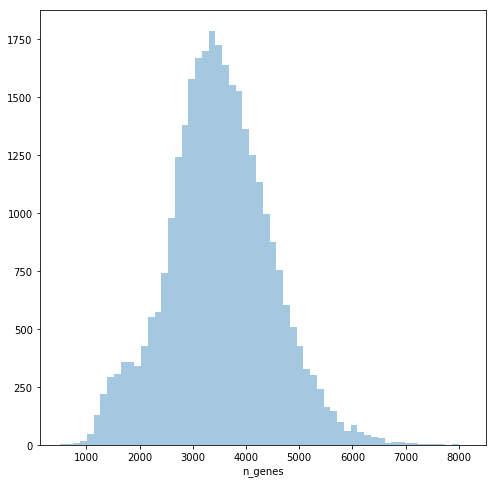

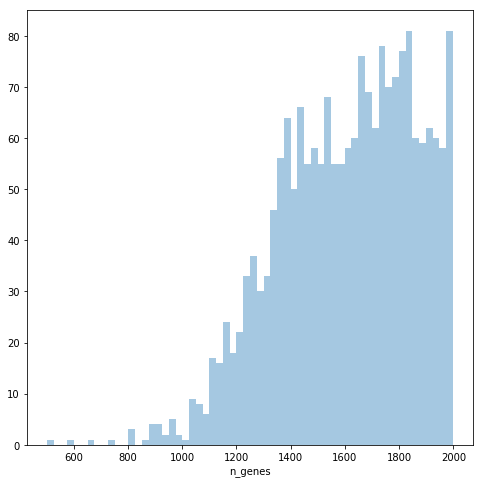

In [12]:
#Thresholding decision: genes
p6 = sb.distplot(adata_pat.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata_pat.obs['n_genes'][adata_pat.obs['n_genes']<2000], kde=False, bins=60)
plt.show()


In [30]:
# Create a nice QC plot for the paper
adata_pat.obs['Total counts'] = adata_pat.obs['n_counts']
adata_pat.obs['Number of genes'] = adata_pat.obs['n_genes']

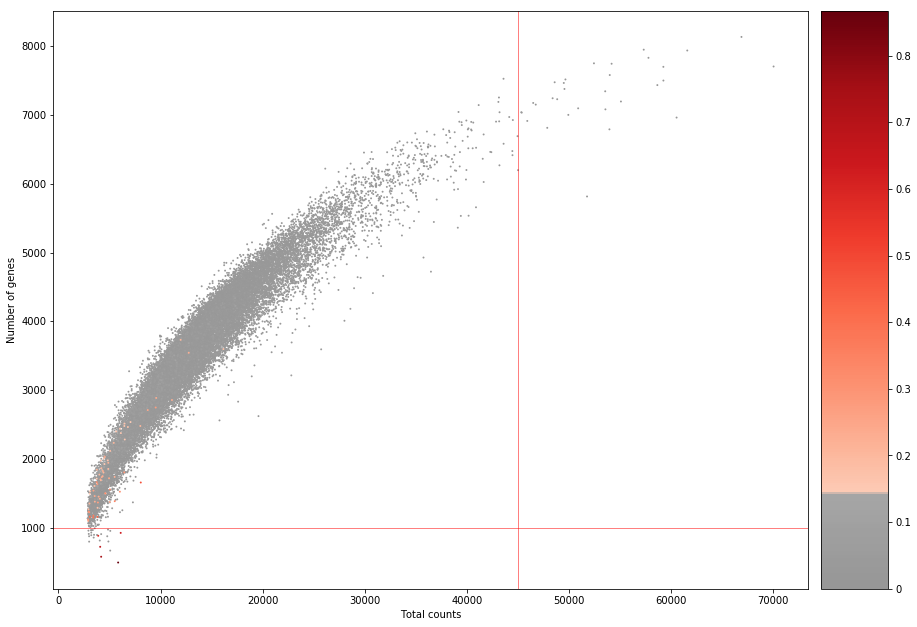

In [34]:
# QC plot for manuscript
plt.rcParams['figure.figsize']=(11,11) #rescale figures
p1 = sc.pl.scatter(adata_pat, 'Total counts', 'Number of genes', color_map=mymap, color='mt_frac', show=False, title="", size=15)
p1.axvline(45000,0,9000, color='red', linewidth=0.5)
p1.axhline(1000,0,75000, color='red', linewidth=0.5)
plt.savefig('figures/scatter_figure_qcplot_thresholds.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

In [13]:
#Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_pat.n_obs))

sc.pp.filter_cells(adata_pat, max_counts = 45000)
print('Number of cells after max count filter: {:d}'.format(adata_pat.n_obs))

adata_pat = adata_pat[adata_pat.obs['mt_frac'] < 0.15]
print('Number of cells after MT filter: {:d}'.format(adata_pat.n_obs))

sc.pp.filter_cells(adata_pat, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata_pat.n_obs))

Total number of cells: 30676
filtered out 32 cells that have more than  45000 counts
Number of cells after max count filter: 30644
Number of cells after MT filter: 30577
filtered out 20 cells that have less than 1000 genes expressed
Number of cells after gene filter: 30557


In [14]:
#Filter cells according to ambiguous reads and doublets
print('Total number of cells: {:d}'.format(adata_pat.n_obs))

adata_pat = adata_pat[adata_pat.obs['Demux_state'] == 'SNG', :]
print('Number of cells after demux filter: {:d}'.format(adata_pat.n_obs))


Total number of cells: 30557
Number of cells after demux filter: 30557


In [15]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_pat.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_pat, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_pat.n_vars))

Total number of genes: 58735
filtered out 33815 genes that are detected in less than 20 cells
Number of genes after cell filter: 24920


# Normalization

In [15]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata_pat.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)


computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:11.20) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:04.42) --> found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical)


In [16]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_pat.X.T

In [17]:
%%R -i data_mat -i input_groups -o size_factors
require(scran)

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [18]:
#Delete adata_pat_pp
del adata_pp

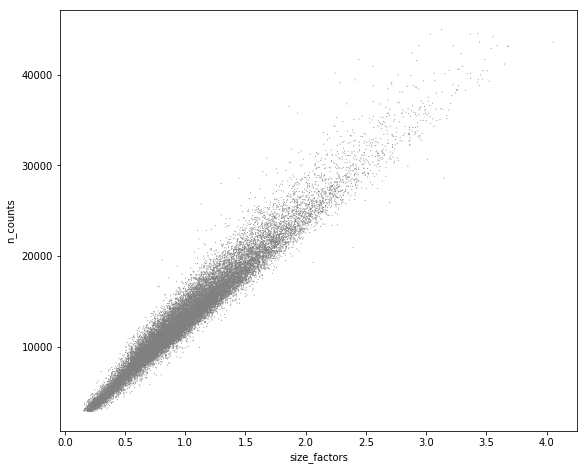

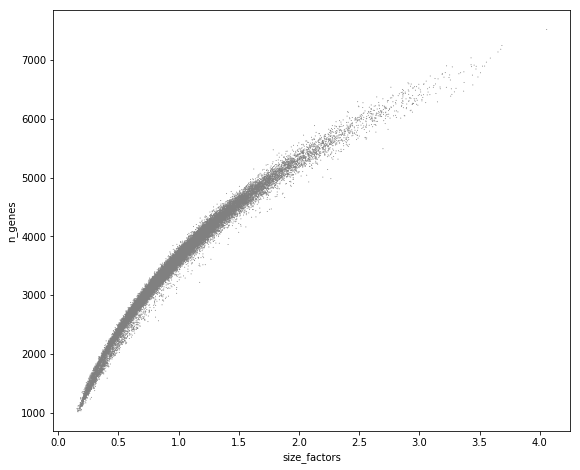

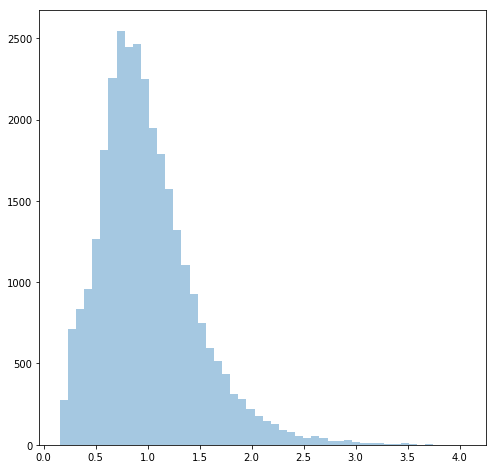

In [19]:
# Visualize the estimated size factors
adata_pat.obs['size_factors'] = size_factors

sc.pl.scatter(adata_pat, 'size_factors', 'n_counts')
sc.pl.scatter(adata_pat, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

In [20]:
#Keep the count data in a counts layer
adata_pat.layers["counts"] = adata_pat.X.copy()

In [21]:
#Normalize adata_pat 
adata_pat.X /= adata_pat.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_pat)

In [22]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata_pat.raw = adata_pat

# Data summary statistics

In [5]:
adata_pat.obs['Donor'].value_counts()

ERF07E07    4582
ERF20E03    3446
ERF25E02    3279
ERF16E39    3232
ERF23E03    2979
ERF30E05    2746
ERF10E07    2693
ERF03E15    2163
ERF24E01    2157
ERF04E18    1394
ERF06E05    1034
ERF31E02     852
Name: Donor, dtype: int64

In [8]:
#Recalculate total counts after filtering
adata_pat.obs['total_counts'] = adata_pat.layers['counts'].sum(1)

In [20]:
adata_pat.obs.groupby(by='Donor')['total_counts'].median()

Donor
ERF03E15    15820.0
ERF04E18    12052.0
ERF06E05    11693.5
ERF07E07    13102.0
ERF10E07    13293.0
ERF16E39    11062.0
ERF20E03    12628.0
ERF23E03    14244.0
ERF24E01    10390.0
ERF25E02    12508.0
ERF30E05    10220.0
ERF31E02    13369.5
Name: total_counts, dtype: float32

# Highly Variable Genes

In [23]:
# Check highly variable gene selection to look at the results
sc.pp.highly_variable_genes(adata_pat, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_pat.var['highly_variable'])))

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


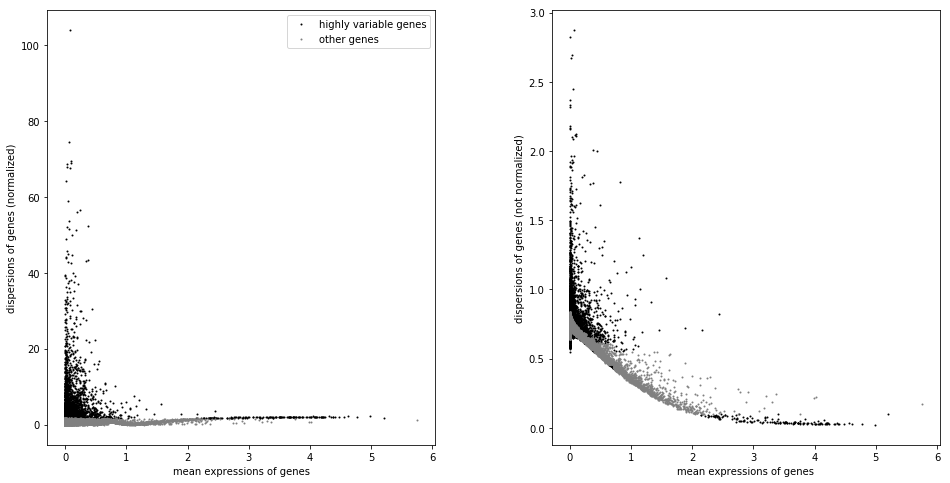

In [24]:
#Plot the highly variable genes
sc.pl.highly_variable_genes(adata_pat)

# Dimensionality reduction (summarization)

In [25]:
sc.pp.pca(adata_pat, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_pat)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:07.64) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


# MNN Data integration

In [31]:
datasets = [adata_pat[adata_pat.obs['Donor'] == d,:].copy() for d in adata_pat.obs['Donor'].cat.categories]

In [32]:
len(datasets)

12

In [33]:
datasets[0]

AnnData object with n_obs × n_vars = 2163 × 24920 
    obs: 'Demux_state', 'Donor', 'Lane', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'size_factors'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [34]:
for d in datasets:
    sc.pp.highly_variable_genes(d, n_top_genes=6000, flavor='cell_ranger', inplace=True)
    
hvgs = [set(d.var_names[d.var['highly_variable']]) for d in datasets]

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values
/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:155: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values
/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:155: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
--> added
    'highly_variable', boolean vect

/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:155: RuntimeWarning: divide by zero encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values
/home/icb/malte.luecken/new_scanpy/scanpy/scanpy/preprocessing/_highly_variable_genes.py:155: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_mad_bin[df['mean_bin'].values].values


In [35]:
# Total number of HVGs found per dataset
[len(i) for i in hvgs]

[6000, 5999, 5999, 6000, 5999, 6000, 5999, 5999, 6791, 5999, 5999, 5999]

In [36]:
# Take the intersection of the HVGs to calculate mutual nearest neighbours for MNN data integration
hvg_intersect = hvgs[0].intersection(*hvgs[1:12])
len(hvg_intersect)

In [38]:
adata_pat_mnn = sce.pp.mnn_correct(*datasets, var_subset=list(hvg_intersect), batch_key="donor")

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 11: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 11: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 3 of 11: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 4 of 11: processing batch 4
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 5 of 11: processing batch 5
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 6 of 11: processing batch 6
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 7 of 11: processing batch 7
  Looking for MNNs...
  Computing correction vectors.

## HVGs & Dimensionality reduction on MNN integrated data

In [43]:
mnn_pairing = adata_pat_mnn[1]
adata_pat_mnn = adata_pat_mnn[0]

In [102]:
adata_pat_mnn.var.columns

Index(['n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0',
       'dispersions_norm-0', 'n_cells-1', 'highly_variable-1', 'means-1',
       'dispersions-1', 'dispersions_norm-1', 'n_cells-2', 'highly_variable-2',
       'means-2', 'dispersions-2', 'dispersions_norm-2', 'n_cells-3',
       'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3',
       'n_cells-4', 'highly_variable-4', 'means-4', 'dispersions-4',
       'dispersions_norm-4', 'n_cells-5', 'highly_variable-5', 'means-5',
       'dispersions-5', 'dispersions_norm-5', 'n_cells-6', 'highly_variable-6',
       'means-6', 'dispersions-6', 'dispersions_norm-6', 'n_cells-7',
       'highly_variable-7', 'means-7', 'dispersions-7', 'dispersions_norm-7',
       'n_cells-8', 'highly_variable-8', 'means-8', 'dispersions-8',
       'dispersions_norm-8', 'n_cells-9', 'highly_variable-9', 'means-9',
       'dispersions-9', 'dispersions_norm-9', 'n_cells-10',
       'highly_variable-10', 'means-10', 'dispersions-1

In [ ]:
adata_pat_mnn.var = adata_pat_mnn.var.drop(columns=adata_pat_mnn.var.columns)

In [99]:
# Run highly variable gene selection on integrated data and look at the results
sc.pp.highly_variable_genes(adata_pat_mnn, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_pat.var['highly_variable'])))

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


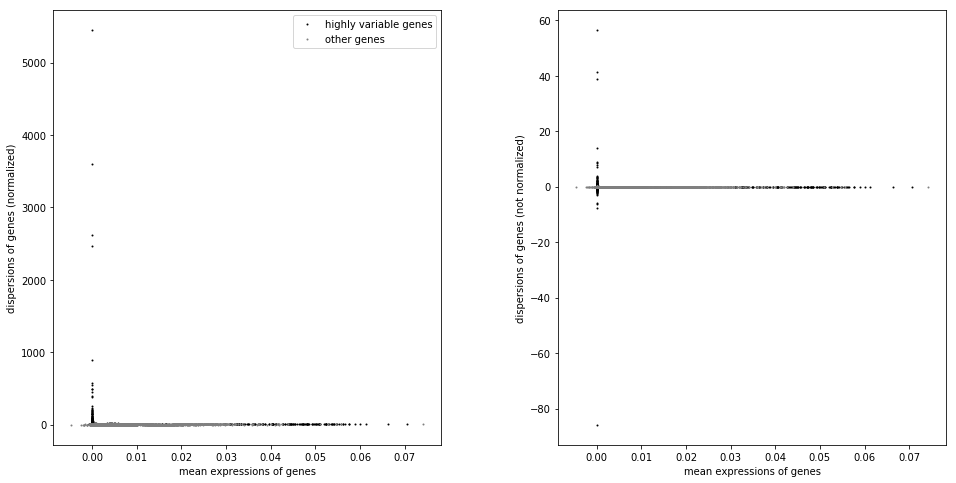

In [100]:
#Plot the highly variable genes
sc.pl.highly_variable_genes(adata_pat_mnn)

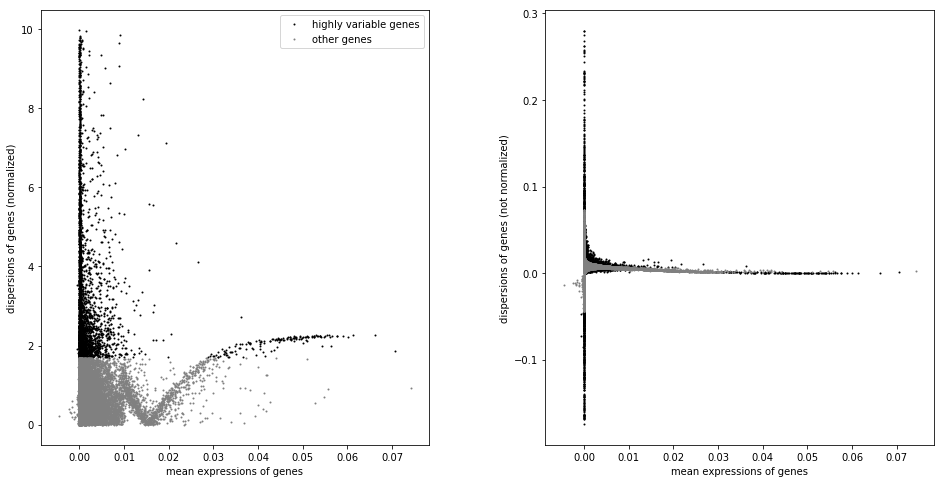

In [129]:
test = adata_pat_mnn[:,np.flatnonzero(adata_pat_mnn.var["dispersions_norm"] < 10)].copy()
sc.pl.highly_variable_genes(test)


In [118]:
sc.pp.pca(adata_pat_mnn, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata_pat_mnn)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:12.46) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


# Visualization

In [119]:
# Calculate the visualizations
sc.tl.umap(adata_pat_mnn)

computing UMAP
    finished (0:00:26.83) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing UMAP
    finished (0:00:40.34) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing UMAP
    finished (0:00:26.85) --> added
    'X_umap', UMAP coordinates (adata.obsm)


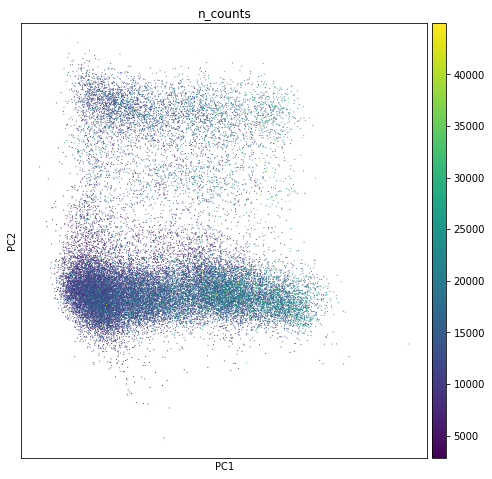

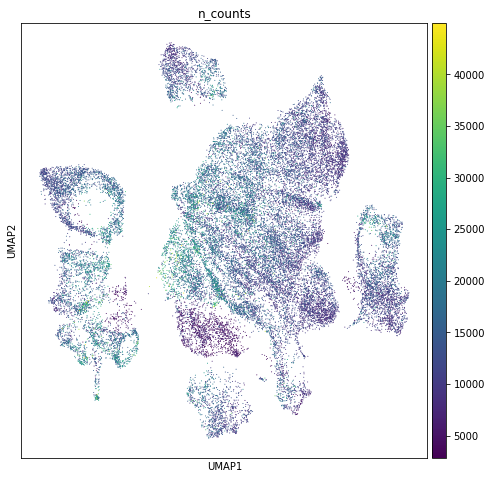

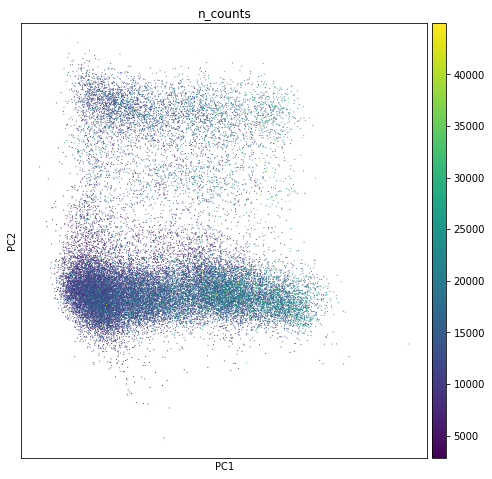

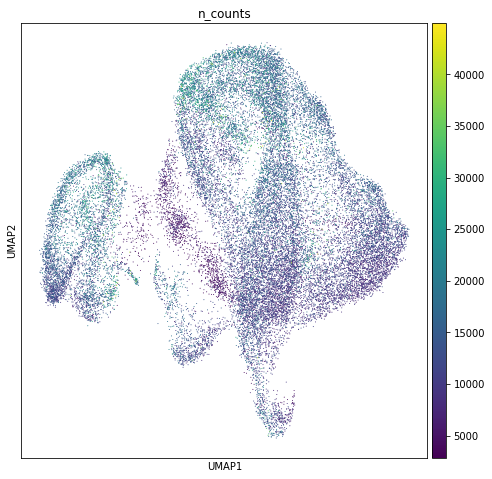

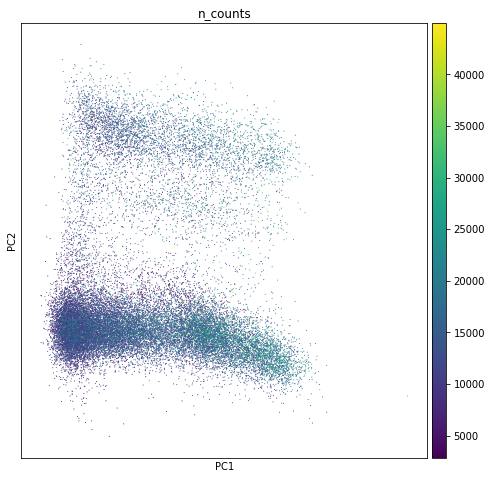

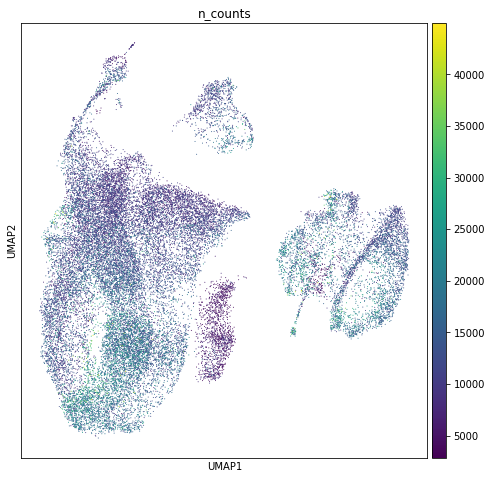

In [120]:
sc.pl.pca_scatter(adata_pat_mnn, color='n_counts', use_raw=False)
sc.pl.umap(adata_pat_mnn, color='n_counts', use_raw=False)

In [121]:
adata_pat_mn.obs['condition'] = ['Control' if d in ['ERF16E39', 'ERF20E03', 'ERF30E05', 'ERF04E18', 'ERF31E02'] else 'Parkinson' for d in adata_pat_mnn.obs['Donor']]

... storing 'condition' as categorical


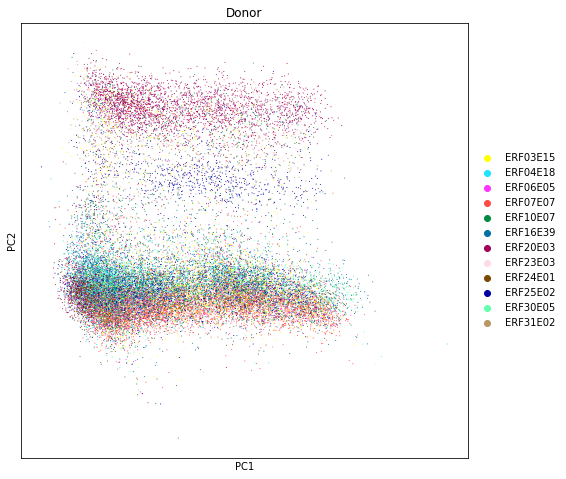

saving figure to file ./figures/umap_nodataint_Donor_dist.pdf


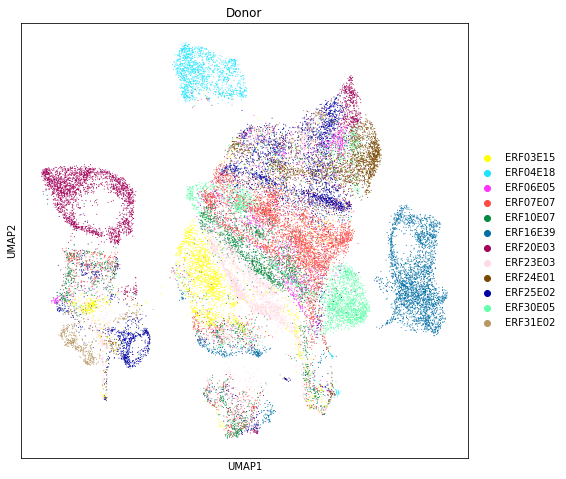

saving figure to file ./figures/umap_nodataint_condition_dist.pdf


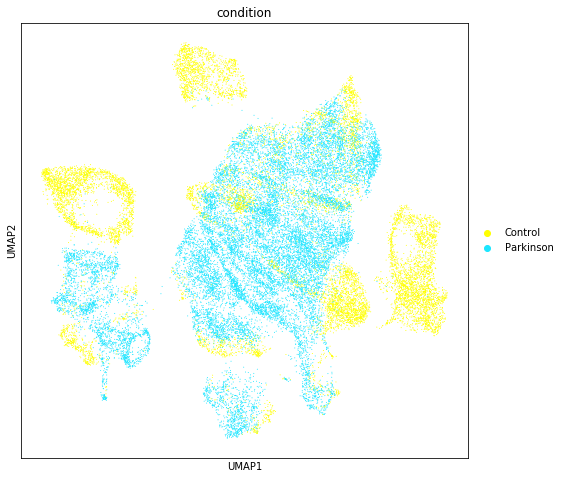

BBKNN


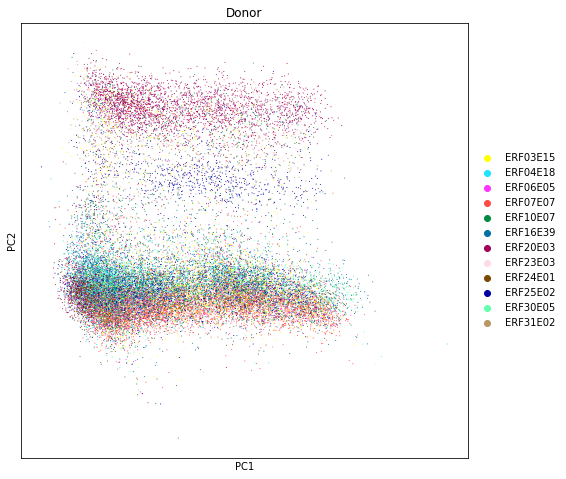

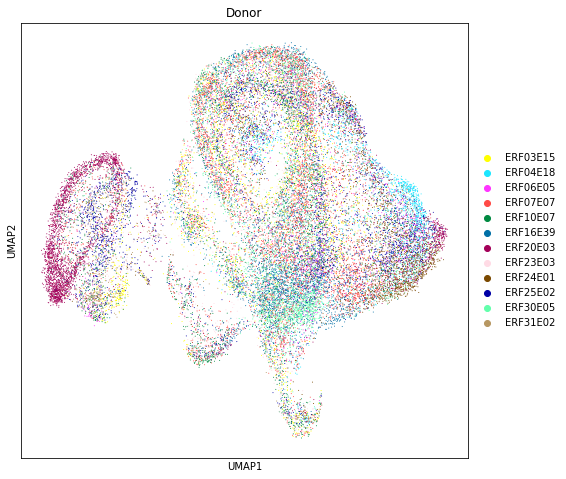

MNN


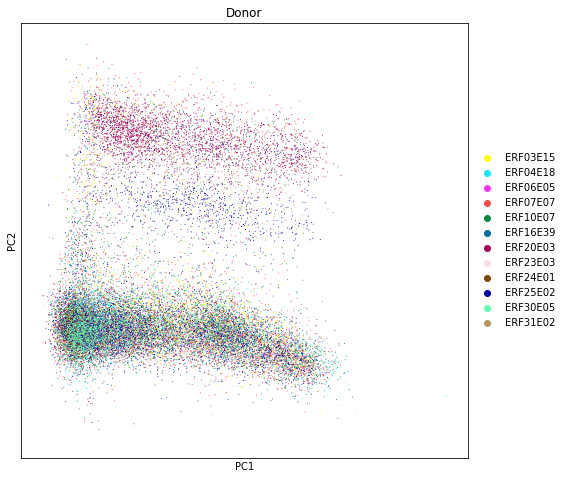

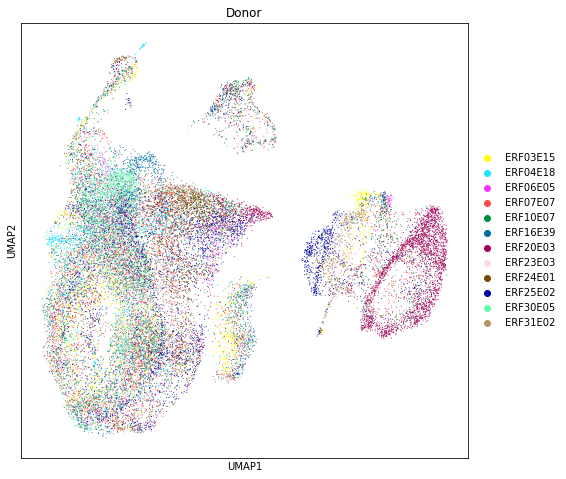

In [122]:
sc.pl.pca_scatter(adata_pat_mnn, color='Donor', use_raw=False, palette=sc.pl.palettes.godsnot_64)
sc.pl.umap(adata_pat_mnn, color='Donor', use_raw=False, palette=sc.pl.palettes.godsnot_64)

# Cell cycle scoring

In [12]:
#Score cell cycle and visualize the effect:
cell_cycle_genes = [x.strip() for x in open(cc_genes_tirosh)]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_pat_mnn.var_names]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


sc.tl.score_genes_cell_cycle(adata_pat_mnn, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:14.54) --> added
    'S_score', score of gene set (adata.obs)
computing score 'G2M_score'
    finished (0:00:14.37) --> added
    'G2M_score', score of gene set (adata.obs)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


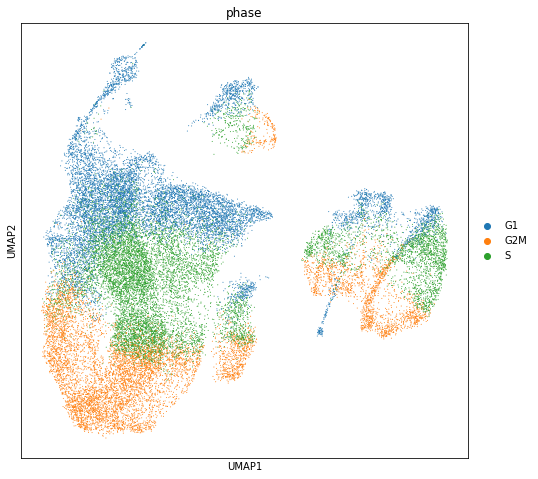

In [13]:
# Tirosh CC gene scoring
sc.pl.umap(adata_pat_mnn, color=['S_score', 'G2M_score'])
sc.pl.umap(adata_pat_mnn, color='phase')

In [85]:
adata_pat_mnn.obs.phase.value_counts()

S      11014
G1     11004
G2M     8539
Name: phase, dtype: int64

# Clustering

In [125]:
# Perform clustering
sc.tl.louvain(adata_pat_mnn, key_added='louvain_r1')
sc.tl.louvain(adata_pat_mnn, resolution=0.5, key_added='louvain_r0.5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:03.39) --> found 25 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:03.14) --> found 14 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:08.77) --> found 10 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:11.61) --> found 8 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:04.45) --> found 17 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical)
running Louvain cluste

In [128]:
adata_pat_mnn.obs['louvain_r0.5'].value_counts()
adata_pat_mnn.obs['louvain_r1'].value_counts()

0    7328
1    4972
2    4553
3    4539
4    3169
5    2035
6    1310
7     984
8     973
9     694
Name: louvain_r0.5, dtype: int64

0     4131
1     3780
2     3185
3     3166
4     2339
5     1847
6     1775
7     1553
8     1380
9     1233
10    1204
11    1003
12     989
13     879
14     803
15     765
16     525
Name: louvain_r1, dtype: int64

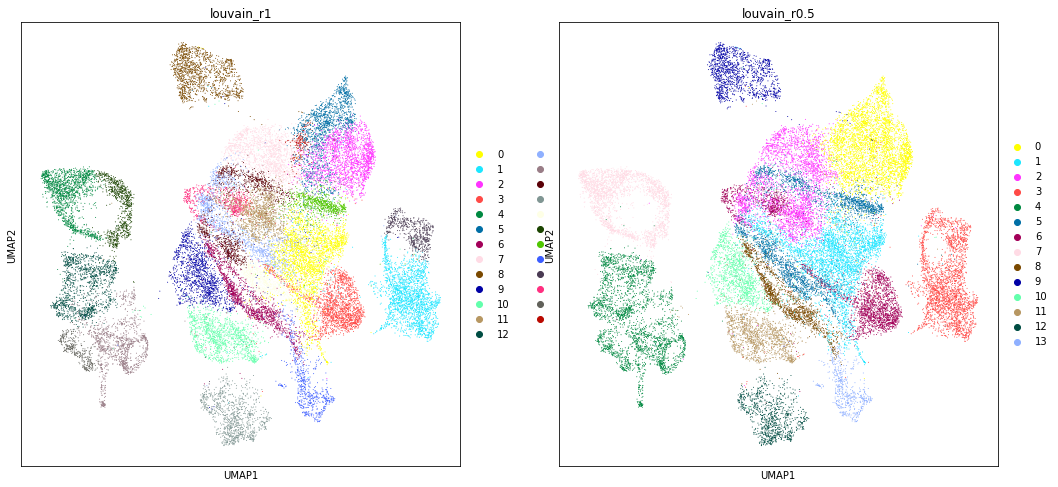

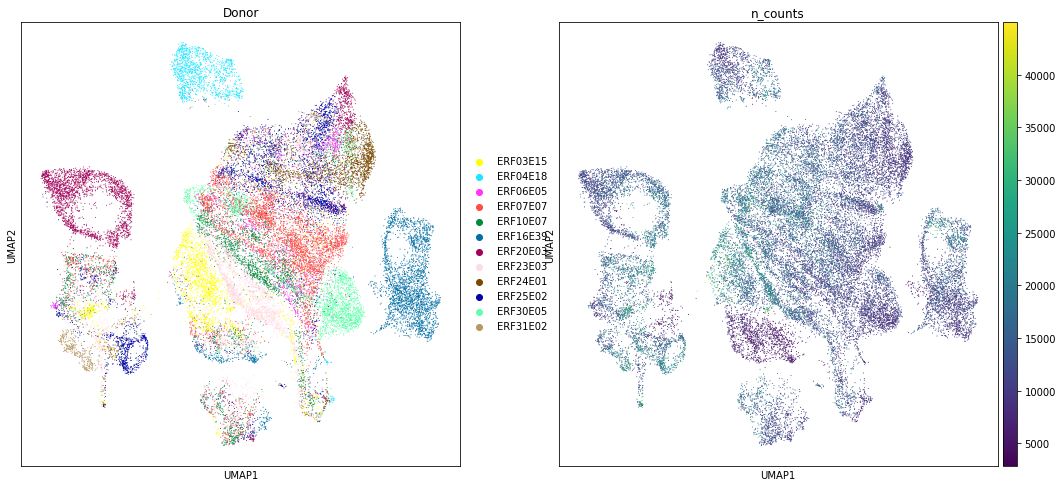

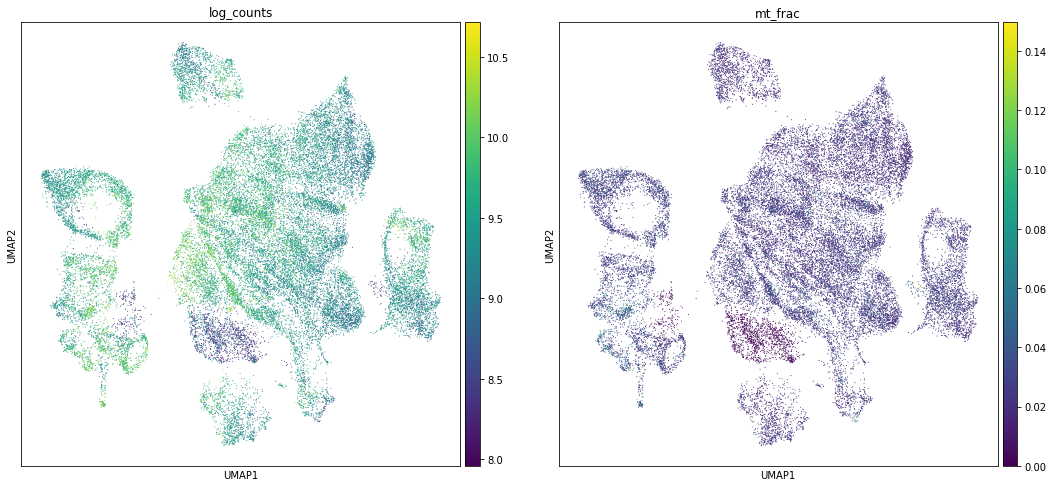

BBKNN


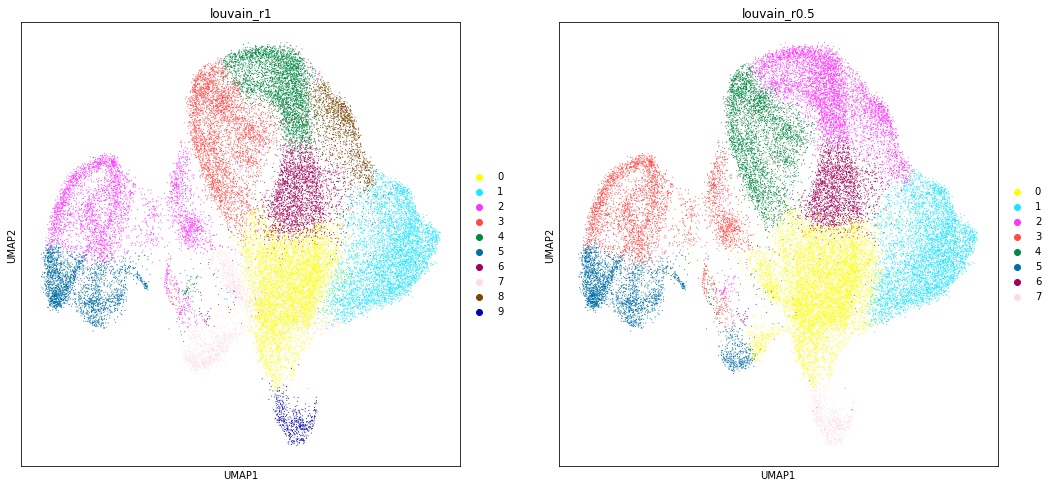

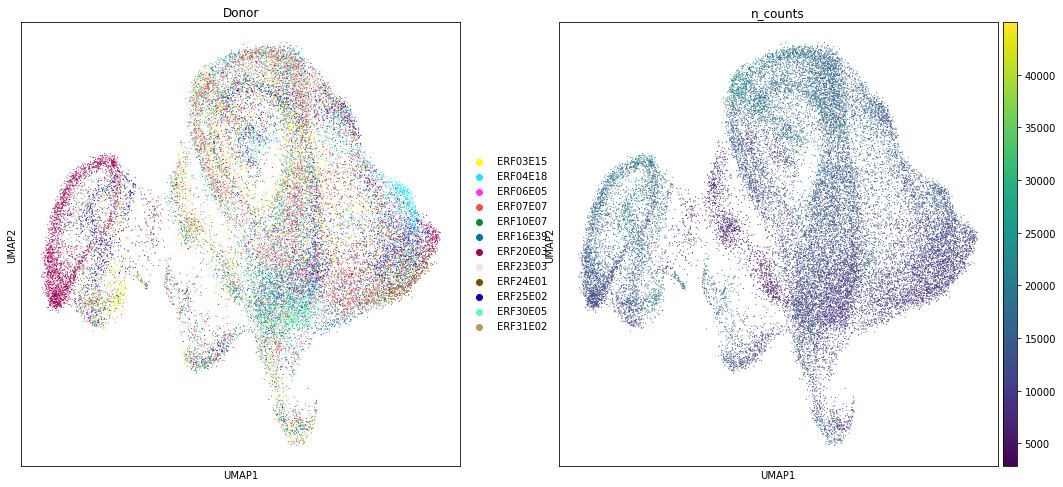

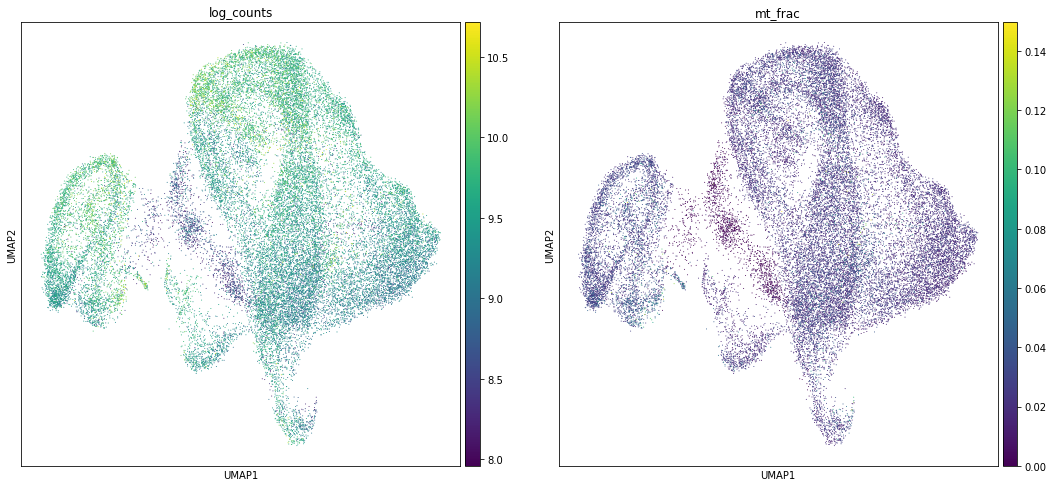

MNN


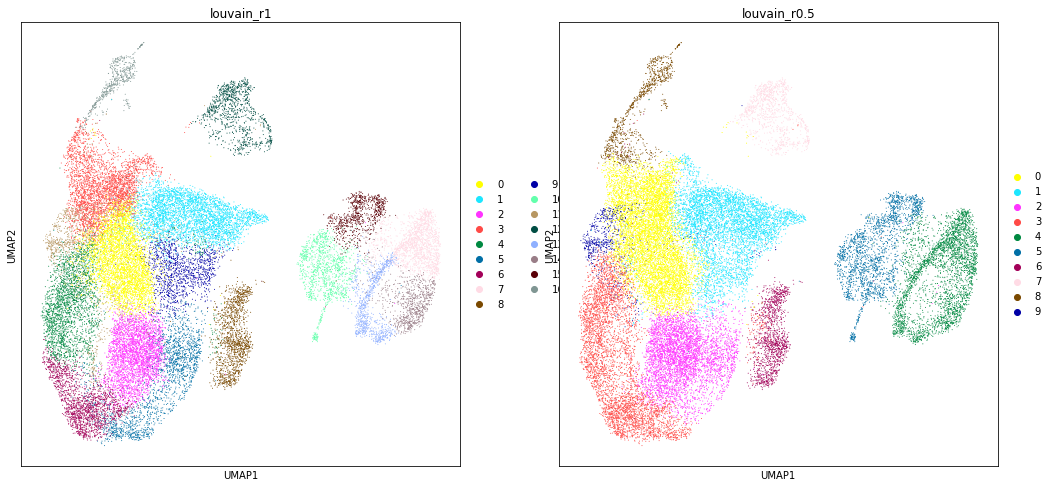

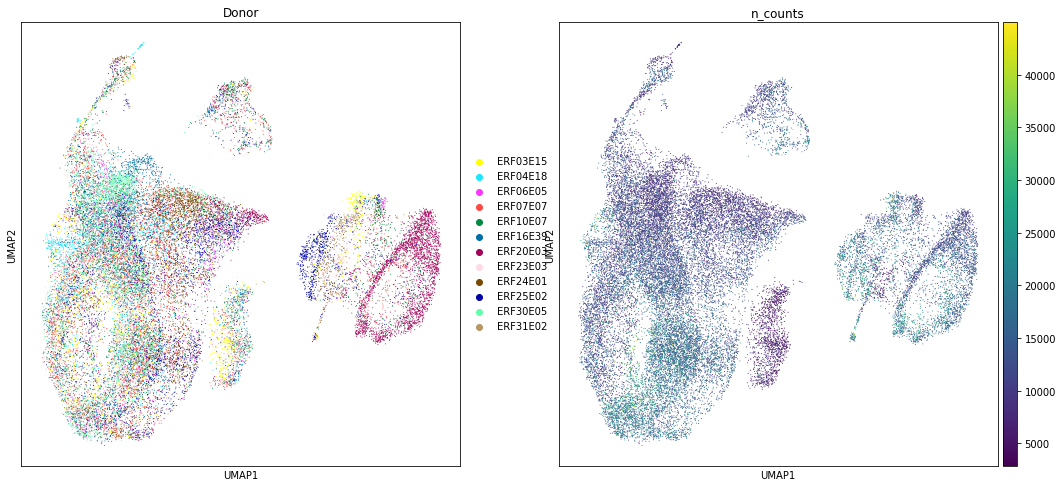

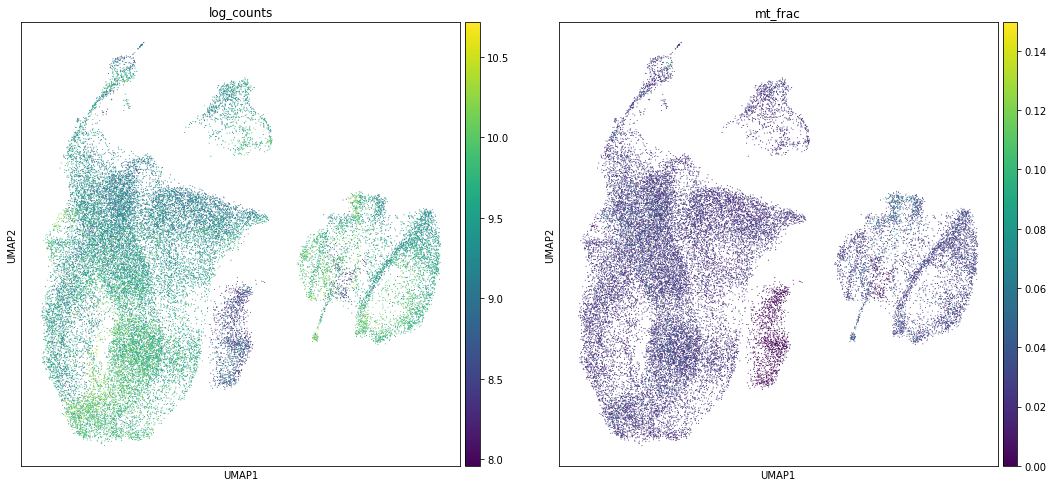

In [132]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata_pat_mnn, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata_pat_mnn, color=['Donor', 'n_counts'])
sc.pl.umap(adata_pat_mnn, color=['log_counts', 'mt_frac'])

# Low-res clustering

In [133]:
sc.tl.louvain(adata_pat_mnn, resolution=0.2, key_added='louvain_r0.2')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:04.79) --> found 6 clusters and added
    'louvain_r0.2', the cluster labels (adata.obs, categorical)


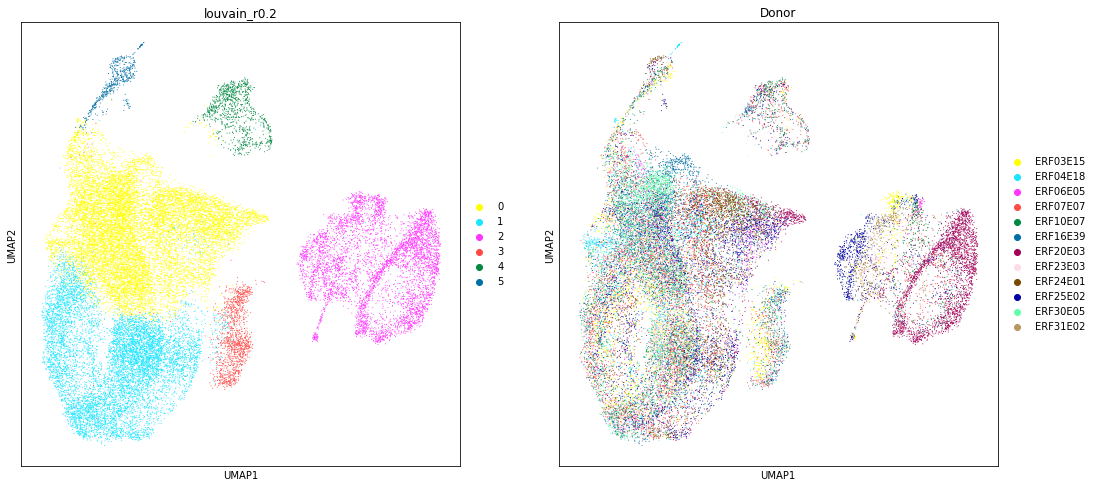

In [134]:
sc.pl.umap(adata_pat_mnn, color=['louvain_r0.2', 'Donor'], palette=sc.pl.palettes.godsnot_64)

# Write data to file

In [135]:
adata_pat_mnn.write(adata_out)